# 제품의 특징과 배송 지연의 상관 관계 분석

## 1. 제품의 특징 정의
### "제품의 특징"을 구체적으로 정의하고 이를 분석 가능한 형태로 정리
* products.csv, order_items.csv에서 제품 관련 정보 확인 가능

### 제품 카테고리
* 변수: product_category_name
* 설명: 제품이 속한 카테고리(예: 전자제품, 가구, 의류 등)
* 분석 이유: 특정 카테고리의 제품이 배송 지연과 관련이 있을 수 있음

### 제품 크기
* 변수: product_length_cm, product_height_cm, product_width_cm
* 설명: 제품의 크기(길이, 높이, 너비)
* 분석 이유: 크기가 큰 제품은 포장 및 배송 과정에서 시간이 더 소요될 가능성이 있음

### 제품 무게
* 변수: product_weight_g
* 설명: 제품의 무게(그램 단위)
* 분석 이유: 무거운 제품은 물류 과정에서 배송 지연이 높을 가능성이 있음

### 제품 배송 처리 시간
* 변수 : product_name_length, product_description_length, product_photo_qty
* 설명 : 제품 설명의 길이 및 사진 수
* 분석 이유 : 제품 설명이 길거나 사진이 많을수록 판매자가 고급 제품으로 취급할 가능성이 있으며, 포장 및 배송 과정이 더 복잡할 수 있음

### 제품 판매 가격
* 변수: price
* 설명: 제품의 가격
* 분석 이유: 고가의 제품은 배송 과정에서 더 신경써야 할 가능성이 있어 배송 시간이 더 걸릴 수 있음

### 제품의 수량
* 변수: order_item_id
* 설명: 주문당 제품의 개수
* 분석 이유: 한 번에 많은 제품이 주문되면 배송 준비 시간이 길어질 가능성이 있음

## 2. 배송 지연 정의

### 예상 배송일과 실제 배송일 비교
* 변수: estimated_delivery_date와 delivered_customer_date
* 설명: 예상 배송일보다 실제 배송일이 늦어진 경우 " 배송 지연"으로 정의

### 배송 소요 시간
* 변수: shipping_limit_date와 delivered_customer_date
* 설명: 배송 준비가 완료된 시점부터 고객에게 도착하기까지의 시간을 계산

## kaggle 데이터셋 다운로드

In [50]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print(path)

/Users/mac/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2


## 데이터 탐색

products (product_id)
* 범주형
- product_id: 고유 제품 식별자
- product_category_name: 제품 핵심 카테고리(포루투갈어)
* 수치형
- product_name_lenght: 제품 이름 길이
- product_description_lenght: 제품 설명 길이
- product_photos_qty: 제품 게시 사진 수
- product_weight_g: 제품 무게(g)
- product_length_cm: 제품 길이(cm)
- product_height_cm: 제품 높이(cm)
- product_width_cm: 제품 너비(cm)

orders (order_id, customer_id)
* 범주형
- order_id: 주문 고유 식별자
- customer_id: 고객 아이디
- order_status: 주문 상태 (전달됨, 발송됨 등)
* datetime
- order_purchase_timestamp: 구매 날짜
- order_approved_at: 주문 승인 날짜
- order_delivered_carrier_date: 물류 파트너에게 처리 날짜 (주문_배달_물류)
- order_delivered_customer_date: 실제 주문 배송 날짜 (주문_배달_고객)
- order_estimated_delivery_date: 구매 시점 고객에게 안내되는 예상 배송 날짜 (주문_예상_배달)

order_items(order_id, product_id)
* 범주형
- order_id: 주문 고유 식별자
- order_item_id: 주문 품목 ID (동일한 주문 포함 품목 번호로 식별, 순차적)
- product_id: 제품 고유 식별자
- seller_id: 판매 고유 식별자
* 수치형
- price: 품목 가격
- freight_value: 주문에 품목이 2개 이상인 경우 운임 가치 품목간 분할(추가 운송료)
* datetime
- shipping_limit_date: 배송 제한 날짜(주문을 물류 파트너에게 처리하기 위한 판매자 배송 제한 날짜)

customer(customer_id)
* 범주형
- customer_id: 고객 아이디
- customer_unique_id: 고객 고유 식별자
* 수치형
- customer_zip_code_prefix: 고객 우편번호(처음 5자리)
- customer_city: 고객 도시 이름
- customer_state: 고객 상태


In [51]:
import pandas as pd
import numpy as np
from datetime import date
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_effectsize
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.metrics import confusion_matrix


In [52]:
# CSV 파일로 읽기
# 제품 관련 데이터
orders = pd.read_csv(os.path.join(path, 'olist_orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(path, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(path, 'olist_products_dataset.csv'))
# sellers = pd.read_csv(os.path.join(path, 'olist_sellers_dataset.csv'))
customers = pd.read_csv(os.path.join(path, 'olist_customers_dataset.csv'))

In [53]:
display(products.head())
display(orders.head())
display(order_items.head())
display(customers.head())
display(len(products), len(orders), len(order_items), len(customers))

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


32951

99441

112650

99441

## 데이터셋 병합

In [54]:
# 주문된 상품만 필요하므로 left join
origin_df = order_items.merge(products, on='product_id', how='left')
# 모든 주문 정보 유지
origin_df = orders.merge(origin_df, on='order_id', how='left')
# 모든 주문 정보 유지
origin_df = origin_df.merge(customers, on='customer_id', how='left')

df = origin_df.copy()

display(df)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,178.0,1.0,400.0,19.0,13.0,19.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,232.0,1.0,420.0,24.0,19.0,21.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,468.0,3.0,450.0,30.0,10.0,20.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,316.0,4.0,250.0,51.0,15.0,15.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,828.0,4.0,4950.0,40.0,10.0,40.0,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,b80910977a37536adeddd63663f916ad,...,500.0,2.0,13300.0,32.0,90.0,22.0,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,1893.0,1.0,6550.0,20.0,20.0,20.0,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,1893.0,1.0,6550.0,20.0,20.0,20.0,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

In [56]:
df.describe()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix
count,112650.000000,112650.000000,112650.000000,111047.000000,111047.000000,111047.000000,112632.000000,112632.000000,112632.000000,112632.000000,113425.000000
mean,1.197834,120.653739,19.990320,48.775978,787.867029,2.209713,2093.672047,30.153669,16.593766,22.996546,35102.472965
std,0.705124,183.633928,15.806405,10.025581,652.135608,1.721438,3751.596884,16.153449,13.443483,11.707268,29864.919733
min,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1003.000000
25%,1.000000,39.900000,13.080000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,11250.000000
50%,1.000000,74.990000,16.260000,52.000000,603.000000,1.000000,700.000000,25.000000,13.000000,20.000000,24320.000000
75%,1.000000,134.900000,21.150000,57.000000,987.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,59020.000000
max,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99990.000000


## 결측치 탐색 및 제거

In [57]:
# 결측값 갯수 확인
display(df.isna().sum())

# 결측값 비율 확인
((df.isna().sum() / len(df)) * 100).round(2)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
product_category_name            2378
product_name_lenght              2378
product_description_lenght       2378
product_photos_qty               2378
product_weight_g                  793
product_length_cm                 793
product_height_cm                 793
product_width_cm                  793
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

order_id                         0.00
customer_id                      0.00
order_status                     0.00
order_purchase_timestamp         0.00
order_approved_at                0.14
order_delivered_carrier_date     1.74
order_delivered_customer_date    2.85
order_estimated_delivery_date    0.00
order_item_id                    0.68
product_id                       0.68
seller_id                        0.68
shipping_limit_date              0.68
price                            0.68
freight_value                    0.68
product_category_name            2.10
product_name_lenght              2.10
product_description_lenght       2.10
product_photos_qty               2.10
product_weight_g                 0.70
product_length_cm                0.70
product_height_cm                0.70
product_width_cm                 0.70
customer_unique_id               0.00
customer_zip_code_prefix         0.00
customer_city                    0.00
customer_state                   0.00
dtype: float

In [58]:
# 결측치들이 3% 미만이기 때문에
# 결측값 제거
df = df.dropna(axis=0, how='any')
df.isna().sum()


order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

In [59]:
# 날짜 데이터 변환
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108643 entries, 0 to 113424
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108643 non-null  object        
 1   customer_id                    108643 non-null  object        
 2   order_status                   108643 non-null  object        
 3   order_purchase_timestamp       108643 non-null  datetime64[ns]
 4   order_approved_at              108643 non-null  datetime64[ns]
 5   order_delivered_carrier_date   108643 non-null  datetime64[ns]
 6   order_delivered_customer_date  108643 non-null  datetime64[ns]
 7   order_estimated_delivery_date  108643 non-null  datetime64[ns]
 8   order_item_id                  108643 non-null  float64       
 9   product_id                     108643 non-null  object        
 10  seller_id                      108643 non-null  object        
 11  shipp

## 특징 변수 선택
* 제품의 특징을 독립 변수로 사용
* 배송 지연 여부(또는 배송 소요 시간)를 종속 변수로 설정

In [60]:
# 배송 지연 여부 (예측 배송 날짜보다 늦게 도착하면 지연)
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).astype(int)
display(df['delivery_delay'][0], df['order_delivered_customer_date'][0], df['order_estimated_delivery_date'][0])

np.int64(-614087000000000)

Timestamp('2017-10-10 21:25:13')

Timestamp('2017-10-18 00:00:00')

In [61]:
# 지연 여부 플래그 생성 (지연: 1, 정상: 0)
df['is_delayed'] = (df['delivery_delay'] > 0).astype(int)

# 지연: 1, 정상: 0 비율 확인
df['is_delayed'].value_counts(normalize=True) * 100

is_delayed
0    92.111779
1     7.888221
Name: proportion, dtype: float64

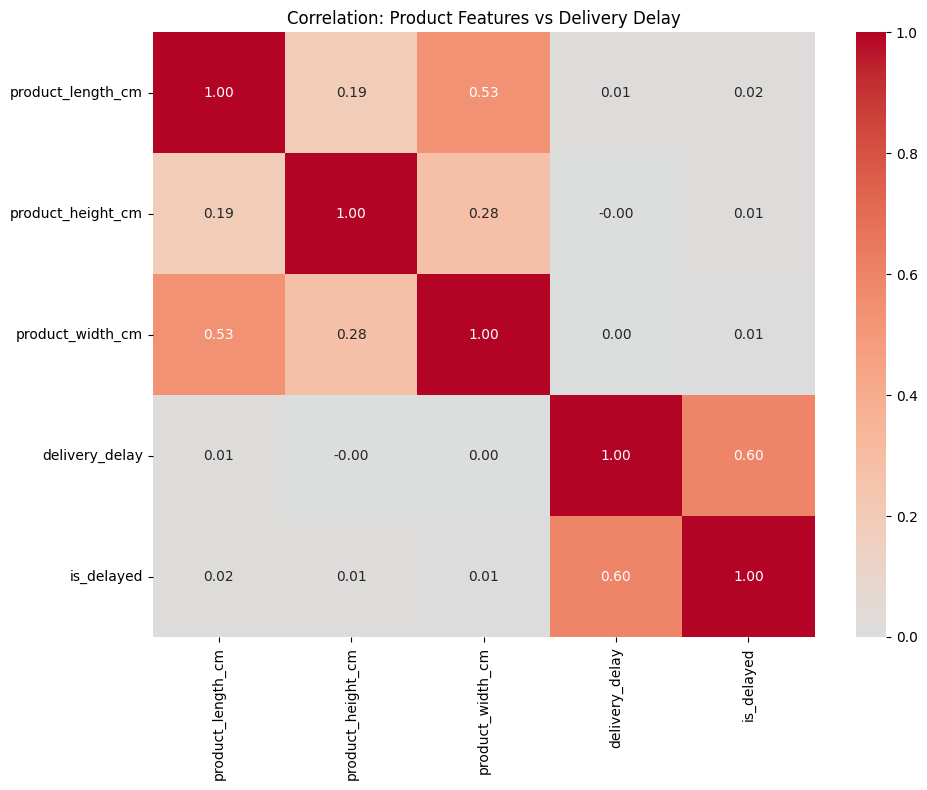

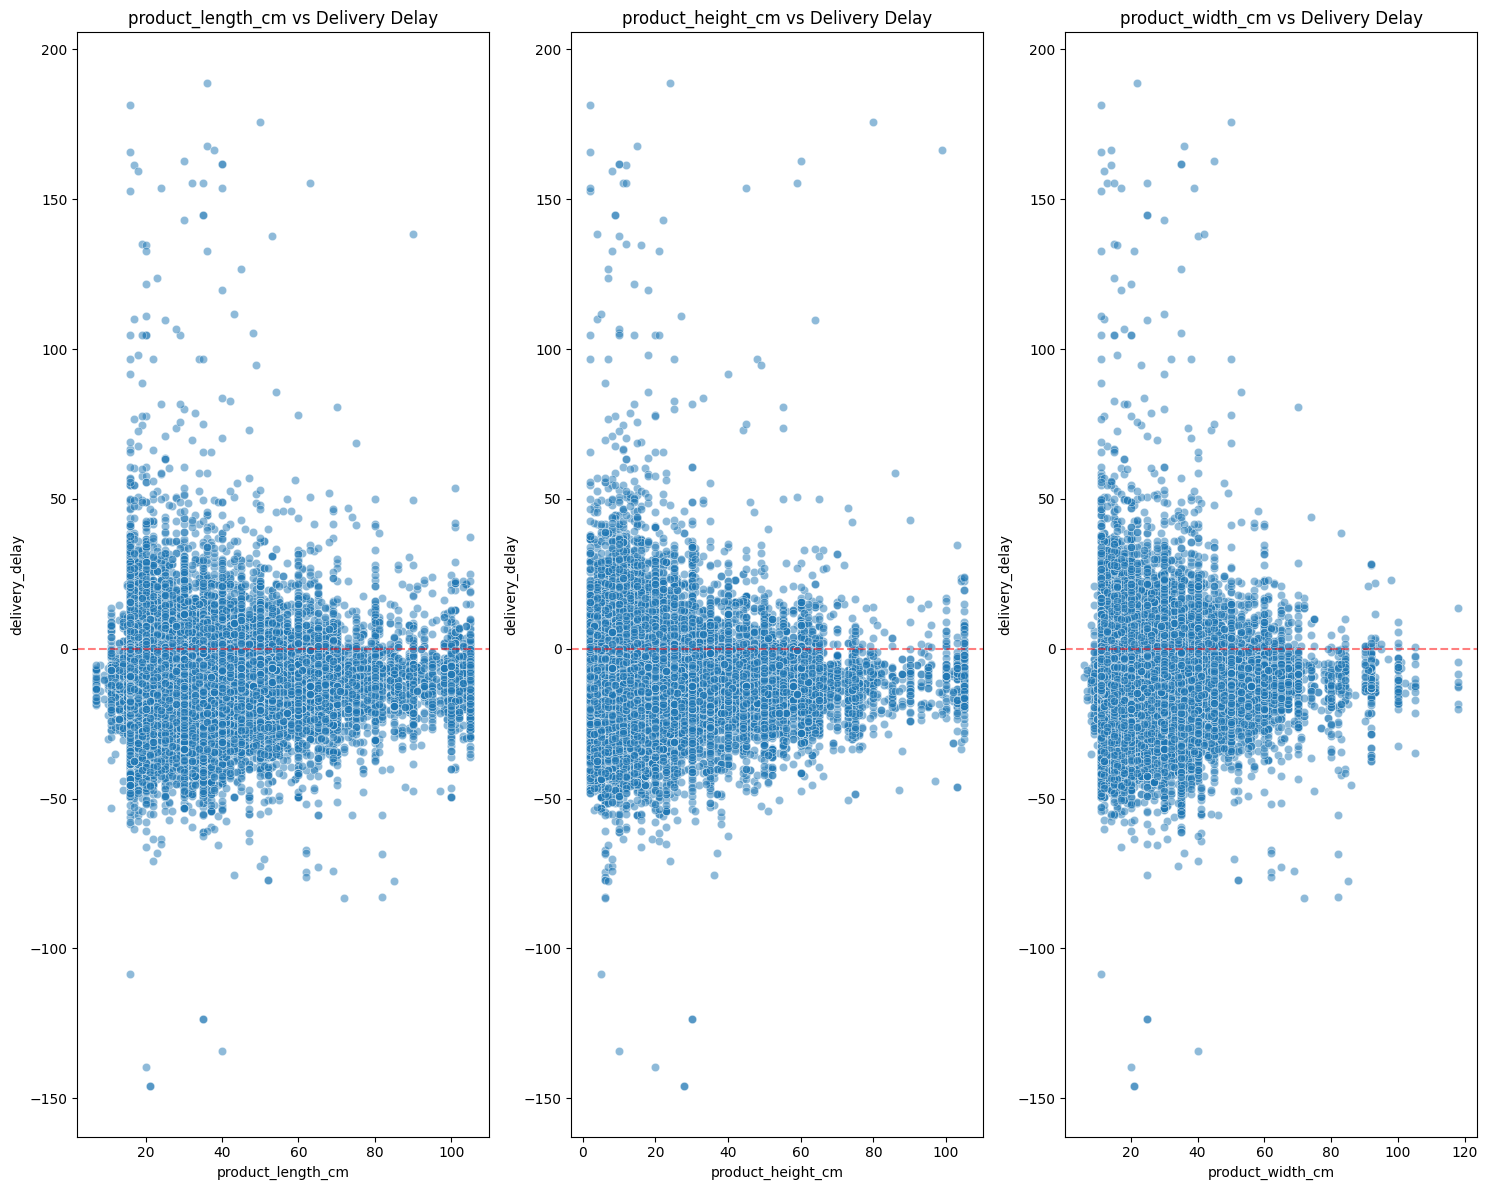

In [64]:
# 1. 분석할 변수 설정
analysis_columns = ['product_weight_g',  'product_length_cm', 'product_height_cm', 'product_width_cm', 
                'delivery_delay', 'is_delayed']

# 3. 상관관계 히트맵
plt.figure(figsize=(10, 8))
corr_matrix = df[analysis_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation: Product Features vs Delivery Delay')
plt.tight_layout()
plt.show()

# 2. 산점도 그리기
fig, axes = plt.subplots(1, 3, figsize=(15, 12))
axes = axes.ravel()

features = ['product_length_cm', 'product_height_cm', 'product_width_cm']

for idx, feature in enumerate(features):
    sns.scatterplot(data=df, x=feature, y='delivery_delay', ax=axes[idx], alpha=0.5)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)  # 지연 기준선
    axes[idx].set_title(f'{feature} vs Delivery Delay')
    
plt.tight_layout()
plt.show()


In [65]:
# 날짜 데이터 변환
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108643 entries, 0 to 113424
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108643 non-null  object        
 1   customer_id                    108643 non-null  object        
 2   order_status                   108643 non-null  object        
 3   order_purchase_timestamp       108643 non-null  datetime64[ns]
 4   order_approved_at              108643 non-null  datetime64[ns]
 5   order_delivered_carrier_date   108643 non-null  datetime64[ns]
 6   order_delivered_customer_date  108643 non-null  datetime64[ns]
 7   order_estimated_delivery_date  108643 non-null  datetime64[ns]
 8   order_item_id                  108643 non-null  float64       
 9   product_id                     108643 non-null  object        
 10  seller_id                      108643 non-null  object        
 11  shipp

In [66]:
print("\n데이터 타입 확인:")
print(df[['order_approved_at', 'order_purchase_timestamp', 
        'order_delivered_carrier_date', 'order_delivered_customer_date', 
        'order_estimated_delivery_date']].dtypes)



데이터 타입 확인:
order_approved_at                datetime64[ns]
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object


In [67]:
# 구매-구매 승인 소요시간
df['승인_소요시간'] = df['order_approved_at'] - df['order_purchase_timestamp']
# 구매 승인-물류처리 소요시간
df['물류처리_소요시간'] = df['order_delivered_carrier_date'] - df['order_approved_at']
# 물류처리-배송 소요시간
df['배송_소요시간'] = df['order_delivered_customer_date'] - df['order_delivered_carrier_date']
# 전체 배송 소요시간(구매-배송)
df['전체_배송시간'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
# 실제배송-예상배송 소요시간
df['배송_지연시간'] = df['order_delivered_customer_date'] - df['order_estimated_delivery_date']

display(df)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_zip_code_prefix,customer_city,customer_state,delivery_delay,is_delayed,승인_소요시간,물류처리_소요시간,배송_소요시간,전체_배송시간,배송_지연시간
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,3149,sao paulo,SP,-7.107488,0,0 days 00:10:42,2 days 08:47:45,6 days 01:30:13,8 days 10:28:40,-8 days +21:25:13
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,47813,barreiras,BA,-5.355729,0,1 days 06:42:50,0 days 11:06:33,12 days 00:56:45,13 days 18:46:08,-6 days +15:27:45
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,75265,vianopolis,GO,-17.245498,0,0 days 00:16:34,0 days 04:54:37,9 days 04:16:29,9 days 09:27:40,-18 days +18:06:29
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,59296,sao goncalo do amarante,RN,-12.980069,0,0 days 00:17:53,3 days 17:54:00,9 days 10:48:43,13 days 05:00:36,-13 days +00:28:42
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,9195,santo andre,SP,-9.238171,0,0 days 01:01:50,0 days 21:26:05,1 days 22:30:28,2 days 20:58:23,-10 days +18:17:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,11722,praia grande,SP,-1.265324,0,0 days 00:11:39,1 days 10:12:05,20 days 18:15:14,22 days 04:38:58,-2 days +17:37:56
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,...,45920,nova vicosa,BA,-5.524803,0,0 days 00:17:33,1 days 05:48:10,23 days 14:31:51,24 days 20:37:34,-6 days +11:24:17
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,28685,japuiba,RJ,-20.018819,0,0 days 00:07:54,3 days 17:58:42,13 days 07:57:51,17 days 02:04:27,-21 days +23:32:54
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,28685,japuiba,RJ,-20.018819,0,0 days 00:07:54,3 days 17:58:42,13 days 07:57:51,17 days 02:04:27,-21 days +23:32:54


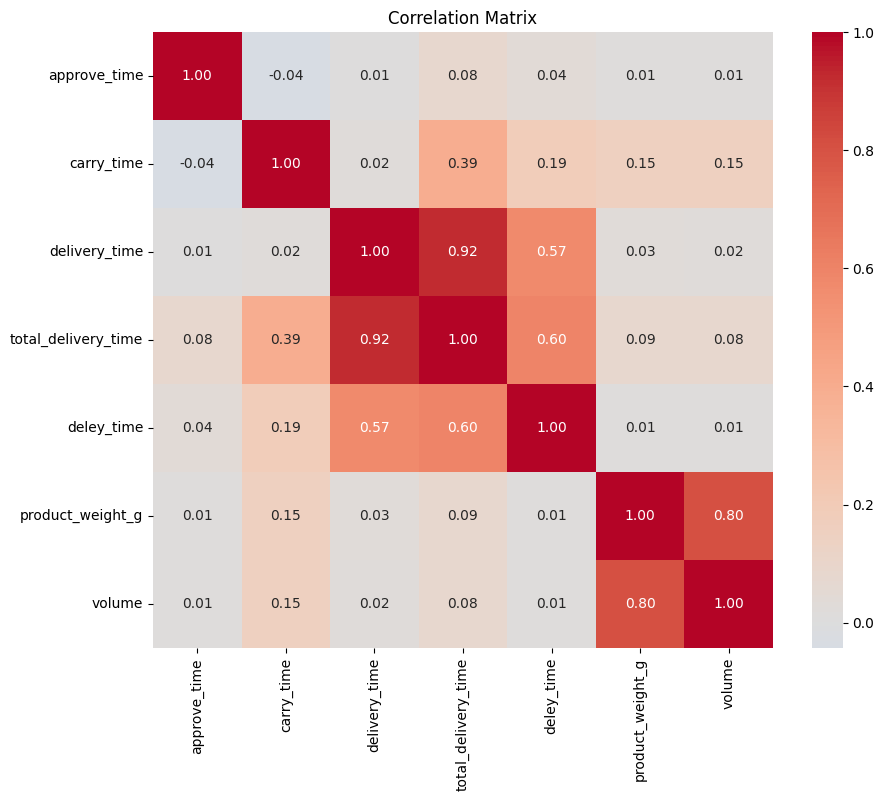

In [68]:
# 시간 데이터를 시간 단위로 변환
df['approve_time'] = df['승인_소요시간'].dt.total_seconds() / 3600
df['carry_time'] = df['물류처리_소요시간'].dt.total_seconds() / 3600
df['delivery_time'] = df['배송_소요시간'].dt.total_seconds() / 3600
df['total_delivery_time'] = df['전체_배송시간'].dt.total_seconds() / 3600
df['deley_time'] = df['배송_지연시간'].dt.total_seconds() / 3600

# 부피 계산
df['volume'] = df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']

# 부피, 무게와의 상관관계 계산
time_cols = ['approve_time', 'carry_time', 'delivery_time', 'total_delivery_time', 'deley_time']
corr_matrix = df[time_cols + ['product_weight_g', 'volume']].corr()

# 결과 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

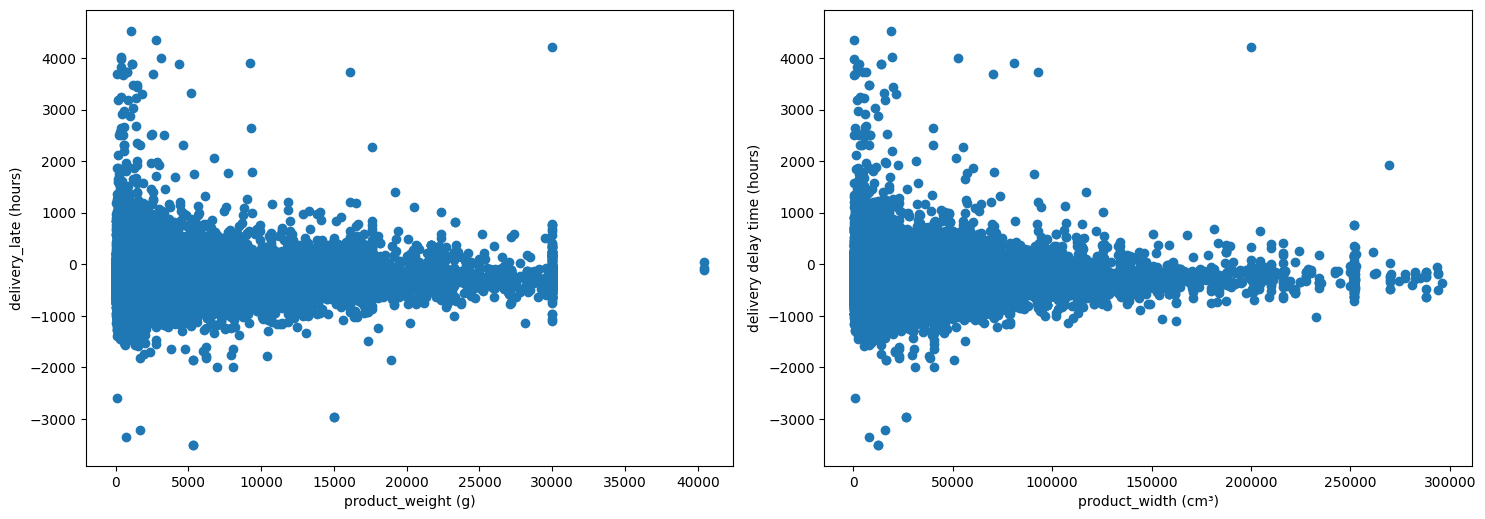

In [69]:
# 시각화
plt.figure(figsize=(15, 10))

# 산점도: 무게 vs 배송 지연시간
plt.subplot(2, 2, 1)
plt.scatter(df['product_weight_g'], df['deley_time'])
plt.xlabel('product_weight (g)')
plt.ylabel('delivery_late (hours)')

# 산점도: 부피 vs 배송 지연시간
plt.subplot(2, 2, 2)
volume = df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']
plt.scatter(volume, df['deley_time'])
plt.xlabel('product_width (cm³)')
plt.ylabel('delivery delay time (hours)')

plt.tight_layout()
plt.show()


지연률 기준 상위 10개 카테고리:
                                    지연률  평균_지연일수  주문_건수
product_category_name                                  
casa_conforto_2                    17.0    -7.79     30
moveis_colchao_e_estofado          14.0    -6.48     37
fashion_underwear_e_moda_praia     13.0   -10.21    127
audio                              13.0    -9.47    362
artigos_de_natal                   12.0   -11.33    150
livros_tecnicos                    11.0   -10.60    263
casa_conforto                      10.0    -9.11    429
construcao_ferramentas_iluminacao  10.0   -10.51    301
alimentos                          10.0    -9.18    499
eletronicos                        10.0   -10.43   2729


/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) mis

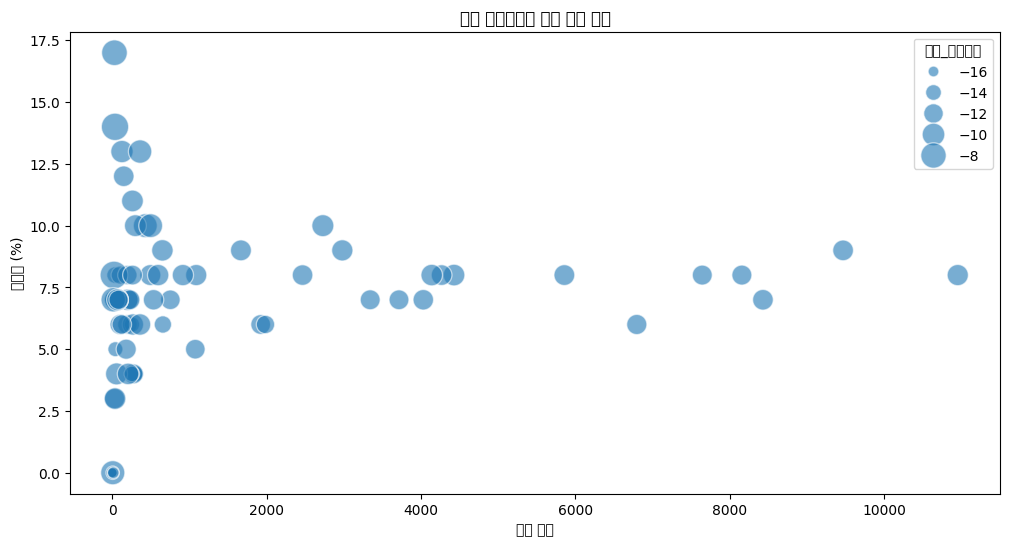

In [70]:
# 1. 카테고리별 지연 지표 계산
카테고리_지연_분석 = df.groupby('product_category_name').agg({
    'delivery_delay': ['mean', 'count'],  # 평균 지연일과 주문 수
    'is_delayed': 'mean'  # 지연률
}).round(2)

# 컬럼명 단순화
카테고리_지연_분석.columns = ['평균_지연일수', '주문_건수', '지연률']

# 지연률 백분율로 변환
카테고리_지연_분석['지연률'] = (카테고리_지연_분석['지연률'] * 100).round(2)

# 지연률 기준으로 정렬
카테고리_지연_분석 = 카테고리_지연_분석.sort_values('지연률', ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(data=카테고리_지연_분석.reset_index(), 
                x='주문_건수', 
                y='지연률',
                size='평균_지연일수',
                sizes=(50, 400),
                alpha=0.6)

plt.title('제품 카테고리별 배송 지연 분석')
plt.xlabel('주문 건수')
plt.ylabel('지연률 (%)')

# 지연률 상위 10개 카테고리 출력
print("\n지연률 기준 상위 10개 카테고리:")
print(카테고리_지연_분석[['지연률', '평균_지연일수', '주문_건수']].head(10))


# casa_conforto_2 -> 홈 컴포트 2 (가정 편의용품 2)
# moveis_colchao_e_estofado -> 가구, 매트리스 및 소파류
# fashion_underwear_e_moda_praia -> 속옷 및 비치웨어
# audio -> 오디오
# artigos_de_natal -> 크리스마스 용품
# livros_tecnicos -> 전문 도서/기술 서적
# casa_conforto -> 홈 컴포트 (가정 편의용품)
# construcao_ferramentas_iluminacao -> 건축 도구 및 조명
# alimentos -> 식품
# eletronicos -> 전자제품



In [71]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

## 분류 모델
* 배송 지연 여부를 예측하기 위한 로지스틱 회귀, 랜덤 포레스트, XGBoost 등 사용 가능

## 회귀 모델
* 배송 소요 시간을 예측하기 위해 선형 회귀, 결정 트리 회귀 등 사용 가능

/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/s

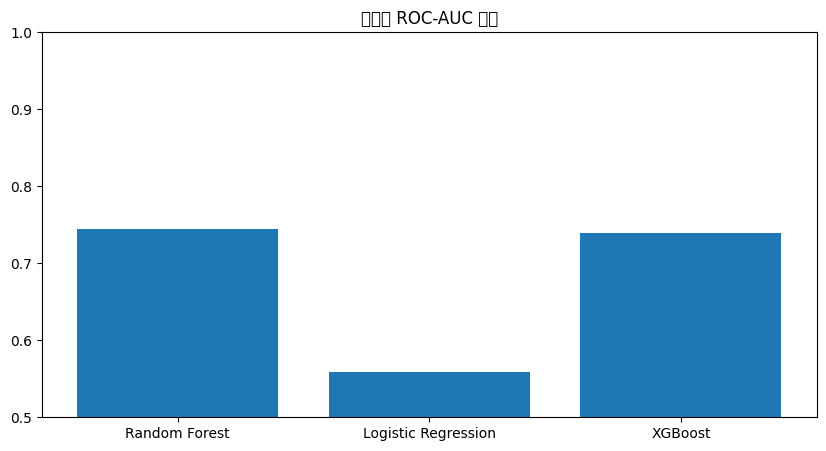

/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mac/opt/anaconda3/envs/python-training/lib/python3.10/

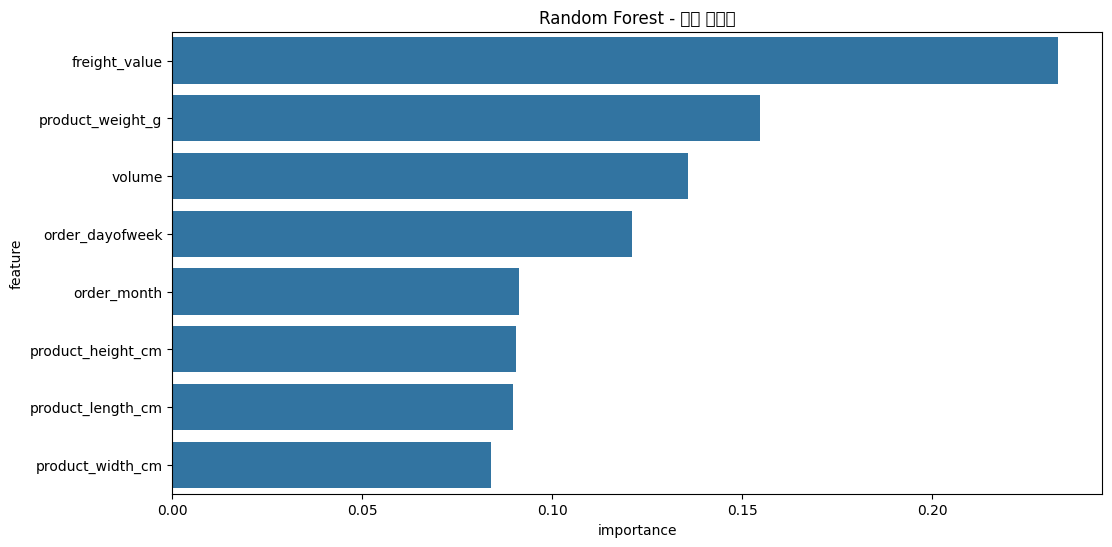


=== 배송 지연 기본 통계 ===
전체 주문 수: 108643.00
지연 배송 수: 7149.00
지연율: 6.58
평균 지연 일수: 10.48

=== 모델별 성능 평가 ===

Random Forest 결과:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     20297
           1       0.59      0.16      0.25      1432

    accuracy                           0.94     21729
   macro avg       0.77      0.58      0.61     21729
weighted avg       0.92      0.94      0.92     21729

ROC-AUC Score: 0.7448

특성 중요도 상위 5개:
            feature  importance
5     freight_value    0.233105
0  product_weight_g    0.154676
4            volume    0.135774
7   order_dayofweek    0.120956
6       order_month    0.091371

Logistic Regression 결과:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     20297
           1       0.00      0.00      0.00      1432

    accuracy                           0.93     21729
   macro avg       0.47      0.50 

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# 1. 데이터 전처리
def prepare_delivery_data(df):
    # 배송 관련 컬럼
    delivered_col = 'order_delivered_customer_date'  # 배송 완료 날짜
    estimated_col = 'order_estimated_delivery_date'  # 배송 예상 날짜
    
    # 날짜 변환 및 배송 지연 계산
    df[delivered_col] = pd.to_datetime(df[delivered_col], errors='coerce')
    df[estimated_col] = pd.to_datetime(df[estimated_col], errors='coerce')
    df['delivery_delay'] = (df[delivered_col] - df[estimated_col]).dt.days
    
    # 결측값 제거
    df = df.dropna(subset=['delivery_delay'])
    
    # 지연 여부 플래그 (1일 이상 지연)
    df['is_delayed'] = (df['delivery_delay'] > 0).astype(int)
    
    # 주문 날짜 관련 컬럼
    order_date_col = 'order_purchase_timestamp'
    df[order_date_col] = pd.to_datetime(df[order_date_col], errors='coerce')
    df['order_month'] = df[order_date_col].dt.month
    df['order_dayofweek'] = df[order_date_col].dt.dayofweek
    
    # 부피 계산
    df['volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
    
    return df

# 2. 특성 선택 및 전처리
def prepare_features(df):
    feature_columns = [
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm',
        'volume',
        'freight_value',
        'order_month',
        'order_dayofweek'
    ]
    
    # NaN 값 처리: 평균값으로 대체
    df = df[feature_columns + ['is_delayed']].copy()
    df = df.fillna(df.mean())  # NaN을 각 컬럼의 평균값으로 대체
    
    X = df[feature_columns]
    y = df['is_delayed']
    
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_columns

# 3. 모델 학습 및 평가
def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_columns):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # 평가 지표
        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        # 특성 중요도 (Random Forest와 XGBoost만)
        if name in ['Random Forest', 'XGBoost']:
            importances = pd.DataFrame({
                'feature': feature_columns,
                'importance': model.feature_importances_
            })
            results[name]['feature_importance'] = importances.sort_values('importance', ascending=False)
    
    return results

# 4. 결과 시각화
def visualize_results(results):
    # 모델별 ROC-AUC 비교
    plt.figure(figsize=(10, 5))
    plt.bar(results.keys(), [res['roc_auc'] for res in results.values()])
    plt.title('모델별 ROC-AUC 점수')
    plt.ylim(0.5, 1)
    plt.show()
    
    # Random Forest 특성 중요도 시각화
    if 'Random Forest' in results:
        plt.figure(figsize=(12, 6))
        rf_importance = results['Random Forest']['feature_importance']
        sns.barplot(x='importance', y='feature', data=rf_importance)
        plt.title('Random Forest - 특성 중요도')
        plt.show()

# 5. 메인 분석 실행
def main_analysis(df):
    # 데이터 전처리
    df = prepare_delivery_data(df)
    
    # 기본 통계
    delay_stats = {
        '전체 주문 수': len(df),
        '지연 배송 수': sum(df['is_delayed']),
        '지연율': sum(df['is_delayed']) / len(df) * 100,
        '평균 지연 일수': df[df['delivery_delay'] > 0]['delivery_delay'].mean()
    }
    
    # 특성 준비
    X_train, X_test, y_train, y_test, feature_columns = prepare_features(df)
    
    # 모델 학습 및 평가
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_columns)
    
    # 결과 시각화
    visualize_results(results)
    
    return delay_stats, results

# 실행 코드
# 데이터프레임 df를 전달하여 실행
# 예: df = pd.read_csv('your_file.csv')
delay_stats, results = main_analysis(df)  # df는 이미 정의된 데이터프레임이어야 합니다.

# 결과 출력
print("\n=== 배송 지연 기본 통계 ===")
for key, value in delay_stats.items():
    print(f"{key}: {value:.2f}")

print("\n=== 모델별 성능 평가 ===")
for model_name, result in results.items():
    print(f"\n{model_name} 결과:")
    print("Classification Report:")
    print(result['classification_report'])
    print(f"ROC-AUC Score: {result['roc_auc']:.4f}")
    
    if model_name in ['Random Forest', 'XGBoost']:
        print("\n특성 중요도 상위 5개:")
        print(result['feature_importance'].head())



[product_weight_g 통계]
평균: 2095.56
중앙값: 700.00
표준편차: 3744.02
이상치 범위: 0.00 ~ 4050.00

[product_length_cm 통계]
평균: 30.20
중앙값: 25.00
표준편차: 16.16
이상치 범위: 0.00 ~ 68.00

[product_height_cm 통계]
평균: 16.59
중앙값: 13.00
표준편차: 13.43
이상치 범위: 0.00 ~ 38.00

[product_width_cm 통계]
평균: 23.03
중앙값: 20.00
표준편차: 11.70
이상치 범위: 0.00 ~ 52.50


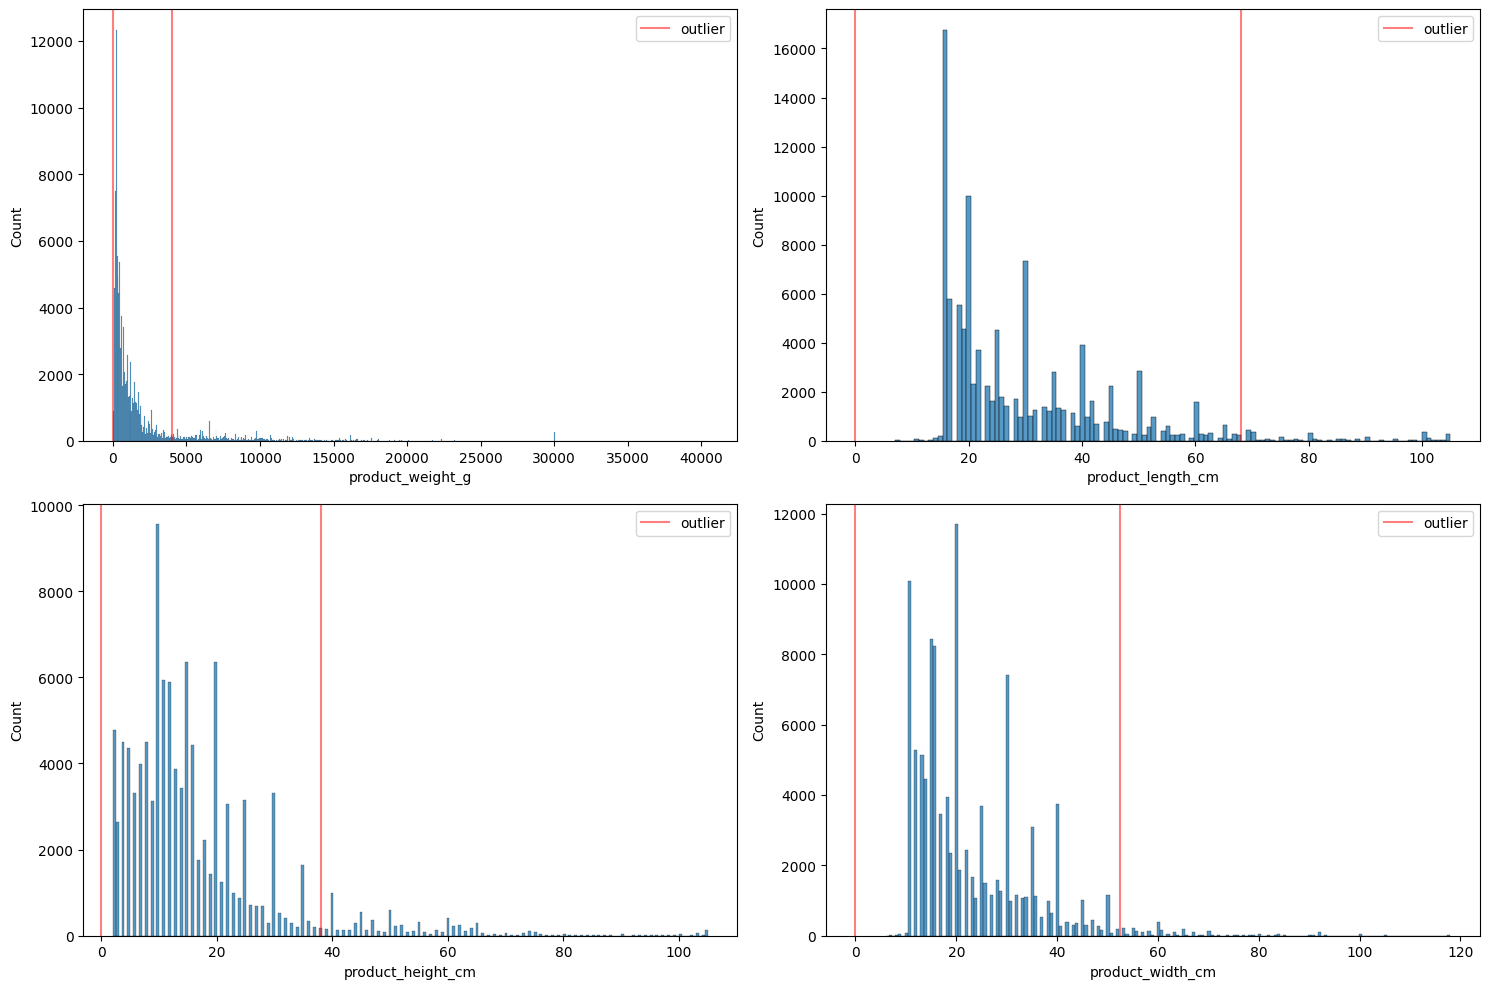

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# 서브플롯 생성 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()  # 2차원 배열을 1차원으로 변환

columns_to_plot = ['product_weight_g','product_length_cm','product_height_cm','product_width_cm']

# 각 변수별 분포 그리기
for idx, column in enumerate(columns_to_plot):
    # histplot 그리기
    sns.histplot(data=df, x=column, stat='count', ax=axes[idx])
    
    # 이상치 통계 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = max(0, Q1 - 1.5 * IQR)  # 음수 방지를 위해 max 사용
    upper = Q3 + 1.5 * IQR
    
    # 이상치 범위 표시
    axes[idx].axvline(lower, color='r', alpha=0.5, label='outlier')
    axes[idx].axvline(upper, color='r', alpha=0.5)
    axes[idx].legend()
    
    # 기술 통계량 출력
    print(f"\n[{column} 통계]")
    print(f"평균: {df[column].mean():.2f}")
    print(f"중앙값: {df[column].median():.2f}")
    print(f"표준편차: {df[column].std():.2f}")
    print(f"이상치 범위: {lower:.2f} ~ {upper:.2f}")

plt.tight_layout()
plt.show()
